In [0]:
 %tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

TensorFlow 1.x selected.


In [0]:
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def reducelogsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """
    Computes the sum of elements across dimensions of a tensor in log domain.
    It uses a similar API to tf.reduce_sum.

    Args:
        input_tensor: The tensor to reduce. Should have numeric type.
        reduction_indices: The dimensions to reduce. 
        keep_dims: If true, retains reduced dimensions with length 1.
    Returns:
        The reduced tensor.
    """

    max_input_tensor1 = tf.reduce_max(input_tensor, 
                                    reduction_indices, 
                                    keep_dims=keep_dims)
 
    max_input_tensor2 = max_input_tensor1

    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
        
    return tf.log(tf.reduce_sum(tf.exp(input_tensor - max_input_tensor2),
                                reduction_indices,
                                keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
    """
    Computes normal softmax nonlinearity in log domain.

    It can be used to normalize log probability.
    The softmax is always computed along the second dim of the input Tensor.     

    Args:
        input_tensor: Unnormalized log probability.
    Returns:
        normalized log probability.
    """

    return input_tensor - reducelogsumexp(input_tensor, reduction_indices=0,
                                           keep_dims=True)

# function to plot graph of loss or accuracy
def plotGraph(title, epochs, dataType, trainSet, validationSet=None, 
              testSet=None):
    plt.figure(figsize=(10,5))
    plt.title(f"{title}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{dataType}")
    plt.plot(range(0, epochs), trainSet, label=f"Training {dataType}")

    if validationSet is not None:
        plt.plot(range(0, epochs), validationSet, label=f"Validation {dataType}")
    if testSet is not None:
        plt.plot(range(0, epochs), testSet, label=f"Test {dataType}")
    plt.legend()
    plt.show()

# function to scatter plot of points and cluster assignments
def plotScatter(title, points, labels, clusterCenter):
    classes = [f'k={i}' for i in range(len(np.unique(labels)))]
    plt.figure(figsize=(10,5))
    plt.title(f"{title}")
    scatter = plt.scatter(points[:,0], points[:,1], c=labels, s=10)
    plt.plot(clusterCenter[:, 0], clusterCenter[:, 1], '*r', markersize=15)
    plt.plot()
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.show()

In [0]:
"""
KMEANS
"""

base = '/content/drive/My Drive/Colab Notebooks/ECE421-IntroductionToMachineLearning/ECE421-Labs/Lab3/'
# base = "/content/drive/My Drive/Colab Notebooks/ECE421/ECE421-Labs/Lab3/"

def getData(use100D=False, is_valid=False):
    # Loading data
    if use100D:
        data = np.load(base + 'data100D.npy')
    else:
        data = np.load(base + 'data2D.npy')

    val_data = []
    
    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    return data, val_data

# Distance function for K-means
def distanceFunc(X, MU):
    """
        Distance function for K-means     

        Args:
            X: is an NxD matrix (N observations and D dimensions)
            MU: is an KxD matrix (K means and D dimensions)
        Returns:
            pair_dist: is the squared pairwise distance matrix (NxK)
    """
    # calculate differences between all pairs of points
    diffs = tf.expand_dims(X, -1) - tf.transpose(MU)
    dist = tf.norm(diffs, axis=1)
    return dist

In [0]:
"""
K-MEANS Algorithm
"""

def KNNGraph(K, D):
	tf.set_random_seed(421)
	data = tf.placeholder(tf.float32, shape=(None, D), name="trainData")
	Mu = tf.Variable(tf.random.normal(shape=[K, D]), name="mu")
	
	distances = distanceFunc(data, Mu)
	loss = tf.math.reduce_sum(tf.math.reduce_min(distances, axis=1, 
	                                             keepdims=True))
 
	optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, 
	                                   beta2=0.99, epsilon=1e-5).minimize(loss)
	
	return data, distances, Mu, loss, optimizer
	
def runKNN(trainingData, K, epochs):

	data, distances, mean, loss, optimizer = KNNGraph(K, trainingData.shape[1])
	
	lossArr = []
	clusterCenter = []
	init = tf.global_variables_initializer()
 
	with tf.Session() as sess:
		sess.run(init)
  
		for i in range(epochs):
			sess.run(optimizer, feed_dict={data: trainingData})
			#dist = sess.run(distances, feed_dict={data: trainingData})
			#print(dist.shape)
			lossVal = sess.run(loss, feed_dict={data: trainingData})

			lossArr.append(lossVal)

		clusterCenter = mean.eval()
		dist = sess.run(distances, feed_dict={data: trainingData})

	print(f"Final Loss: {lossArr[-1]}")
	print('------------------------------------------------')
	print('Percentage of points in each cluster:')
	
	# Find the nearest cluster
	clusterAssignments = np.argmin(dist, axis=1)
 
	for cNum in range(K):
		proportion = (clusterAssignments == cNum).astype(int).sum() / float(len(clusterAssignments))
		print(f'K={cNum}: {np.round(proportion * 100, 2)}%')
  
	plotGraph(f"Loss of K-Means Algorithm, k={K}", epochs, "Loss", lossArr)
	plotScatter(f"Clusters of K-Means Algorithm, k={K}", trainingData, clusterAssignments, clusterCenter)

def runKNNHoldout(trainingData, validationData, K, epochs, plot=True):
	data, distances, mean, loss, optimizer = KNNGraph(K, trainingData.shape[1])
	
	lossArr = []
	clusterCenter = 0
	
	init = tf.global_variables_initializer()
 
	with tf.Session() as sess:
		sess.run(init)
  
		for i in range(epochs):
			sess.run(optimizer, feed_dict={data: trainingData})
			#dist = sess.run(distances, feed_dict={data: trainingData})
			#print(dist.shape)
			lossVal = sess.run(loss, feed_dict={data: trainingData})

			lossArr.append(lossVal)
   
		clusterCenter = mean.eval()
		dist = sess.run(distances, feed_dict={data: trainingData})
		validationLoss = sess.run(loss, feed_dict={data: validationData})

	print(f"Final Training Loss: {lossArr[-1]}")
	print(f'Final Validation Loss: {validationLoss}')
	print('------------------------------------------------')
	print('Percentage of points in each cluster:')	
	clusterAssignments = np.argmin(dist, axis=1)
	for cNum in range(K):
		proportion = (clusterAssignments == cNum).astype(int).sum() / float(len(clusterAssignments))
		print(f'K={cNum}: {np.round(proportion * 100, 2)}%')
	
	if plot:
		plotGraph(f"Loss of K-Means Algorithm, k={K}", epochs, "Loss", lossArr)
		plotScatter(f"Clusters of K-Means Algorithm, k={K}", trainingData, clusterAssignments, clusterCenter)

trainData, _ = getData()

Final Loss: 18677.173828125
------------------------------------------------
Percentage of points in each cluster:
K=0: 100.0%


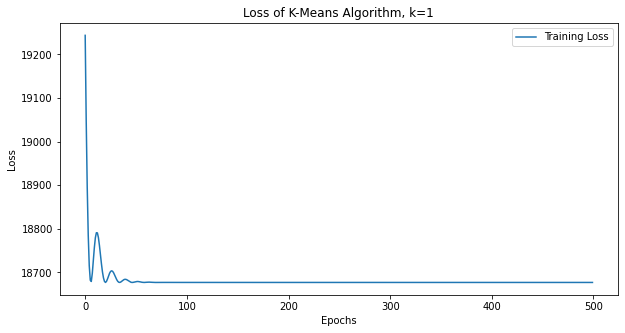

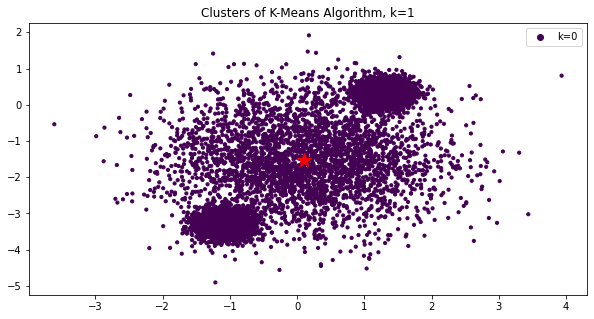

In [0]:
'''
Question 1.1.1 and 1.1.2

K-Means without Validation
'''
runKNN(trainData, K=1, epochs=500)

Final Loss: 4843.64697265625
------------------------------------------------
Percentage of points in each cluster:
K=0: 50.38%
K=1: 49.62%


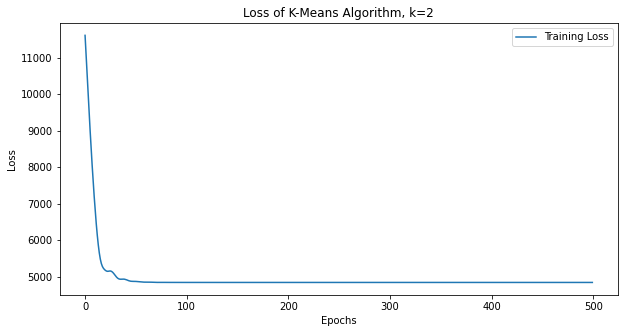

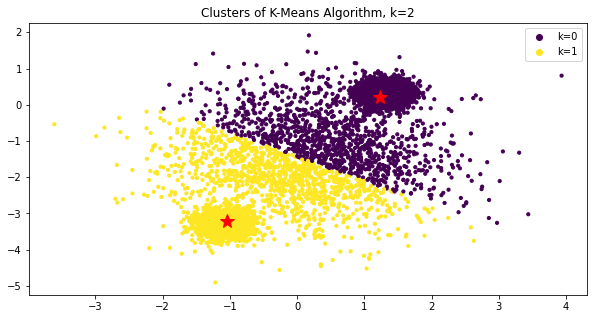

In [0]:
runKNN(trainData, K=2, epochs=500)

Final Loss: 5146.1455078125
------------------------------------------------
Percentage of points in each cluster:
K=0: 37.89%
K=1: 37.86%
K=2: 24.25%


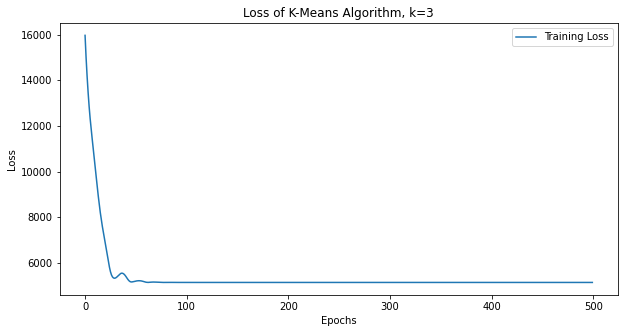

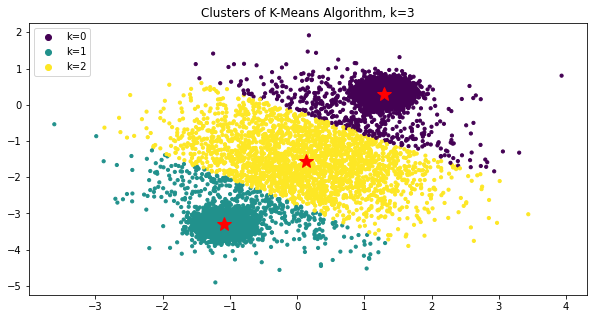

In [0]:
runKNN(trainData, K=3, epochs=500)

Final Loss: 4452.1416015625
------------------------------------------------
Percentage of points in each cluster:
K=0: 37.2%
K=1: 36.92%
K=2: 13.72%
K=3: 12.16%


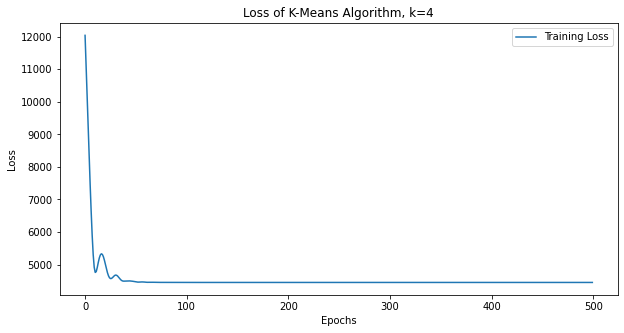

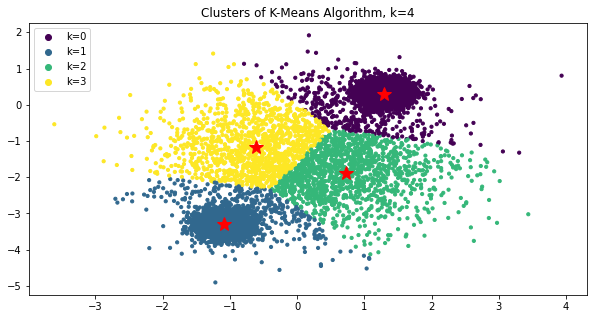

In [0]:
runKNN(trainData, K=4, epochs=500)

Final Loss: 4143.2158203125
------------------------------------------------
Percentage of points in each cluster:
K=0: 11.18%
K=1: 9.14%
K=2: 7.78%
K=3: 36.21%
K=4: 35.69%


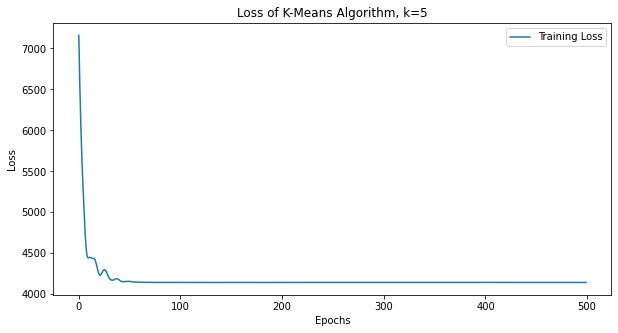

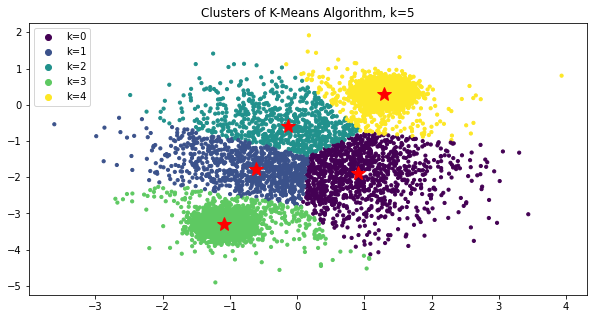

In [0]:
runKNN(trainData, K=5, epochs=500)

Final Training Loss: 12428.576171875
Final Validation Loss: 6252.7529296875
------------------------------------------------
Percentage of points in each cluster:
[[ 0.13781494 -1.4789178 ]]
K=0: 100.0%


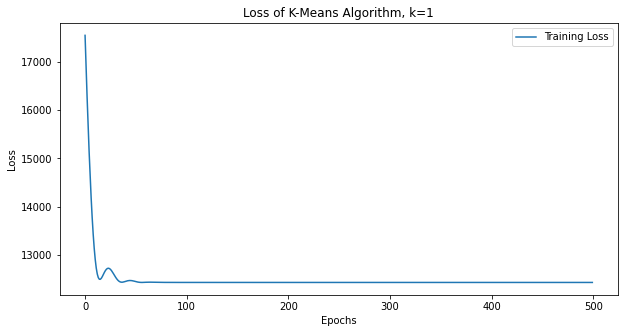

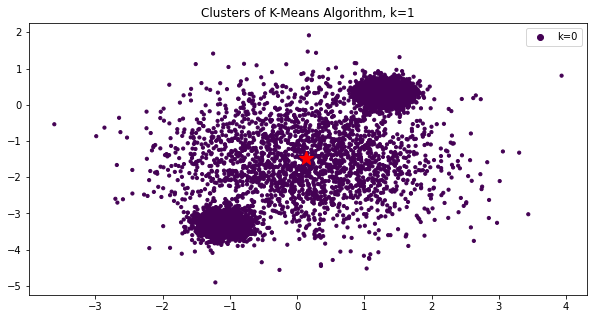

In [0]:
'''
1.1.3

K-Means Algorithm with validation set
'''

trainData, valData = getData(is_valid=True)
runKNNHoldout(trainData, valData, K=1, epochs=500)

Final Training Loss: 4843.537109375
Final Validation Loss: 2340.66845703125
------------------------------------------------
Percentage of points in each cluster:
[[ 1.230304    0.20387593]
 [-1.0325882  -3.196818  ]]
K=0: 50.35%
K=1: 49.65%


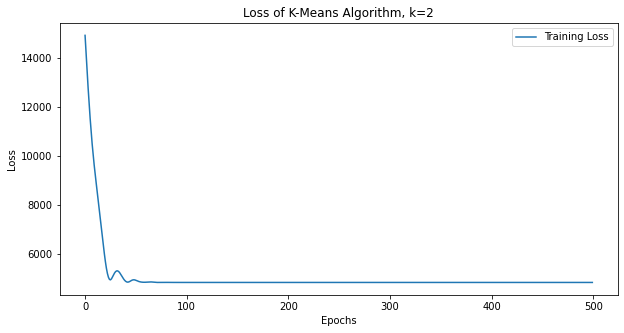

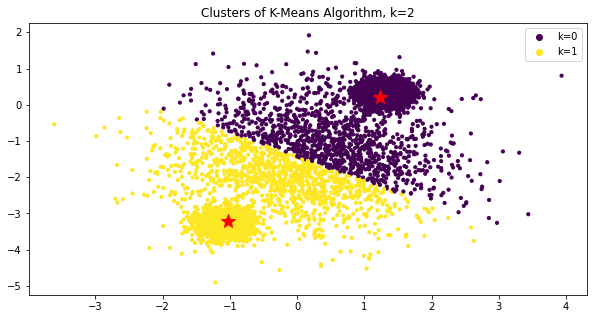

In [0]:
runKNNHoldout(trainData, valData, K=2, epochs=500)

Final Training Loss: 3465.375732421875
Final Validation Loss: 1681.8211669921875
------------------------------------------------
Percentage of points in each cluster:
[[ 1.2801291   0.29308593]
 [ 0.17067634 -1.56675   ]
 [-1.0949472  -3.2886019 ]]
K=0: 38.25%
K=1: 24.6%
K=2: 37.15%


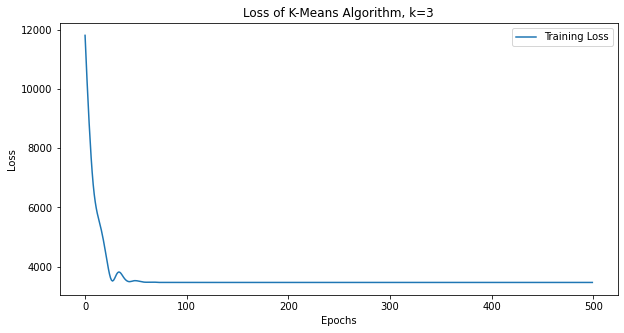

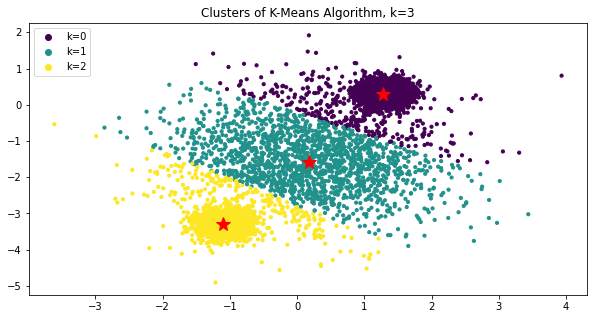

In [0]:
runKNNHoldout(trainData, valData, K=3, epochs=500)

Final Training Loss: 3000.268310546875
Final Validation Loss: 1452.2327880859375
------------------------------------------------
Percentage of points in each cluster:
[[-0.5964798 -1.14989  ]
 [ 0.7426725 -1.8681858]
 [ 1.2829124  0.2952688]
 [-1.0947661 -3.2958372]]
K=0: 12.42%
K=1: 14.01%
K=2: 37.48%
K=3: 36.09%


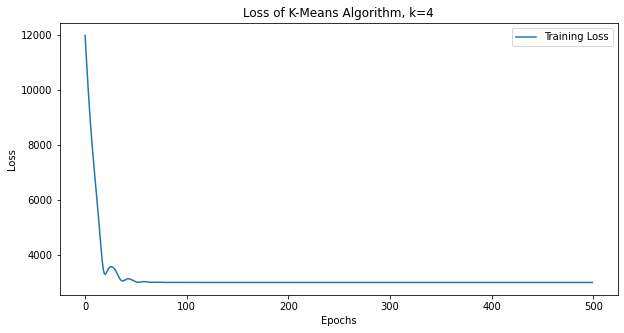

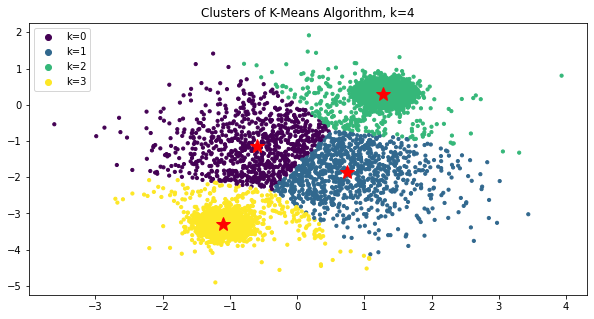

In [0]:
runKNNHoldout(trainData, valData, K=4, epochs=500)

Final Training Loss: 2773.666259765625
Final Validation Loss: 1359.258056640625
------------------------------------------------
Percentage of points in each cluster:
[[ 1.0645857  -1.6618558 ]
 [-1.1058083  -3.3009496 ]
 [ 1.287197    0.29841897]
 [-0.48596862 -0.81503093]
 [-0.14328884 -2.151028  ]]
K=0: 9.67%
K=1: 34.99%
K=2: 36.34%
K=3: 9.93%
K=4: 9.06%


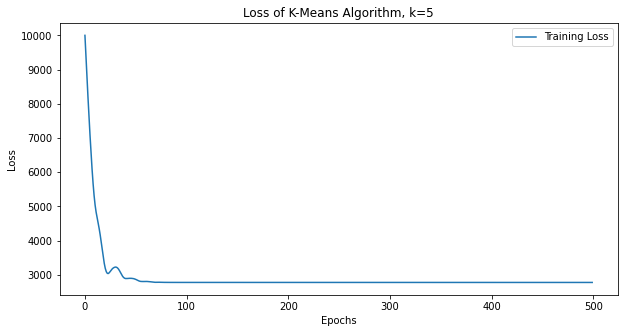

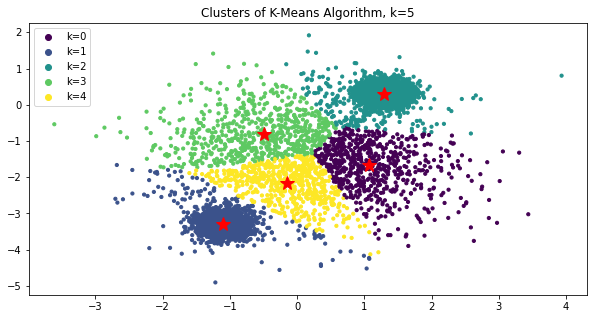

In [0]:
runKNNHoldout(trainData, valData, K=5, epochs=500)

In [0]:
'''
GMM
'''
# same getData function as KNN

# Distance function for GMM 
def distanceFuncGMM(X, MU):
    """
        Distance function for GMM     

        Args:
            X: is an NxD matrix (N observations and D dimensions)
            MU: is an KxD matrix (K means and D dimensions)
        Returns:
            pair_dist: is the squared pairwise distance matrix (NxK)
            (x-u)^2
    """
    # calculate (x-u)^2 for all pairs
    diffs = tf.expand_dims(X, -1) - tf.transpose(MU)
    x_mu2 = tf.reduce_sum(tf.square(diffs), axis=1)
    return x_mu2

def log_GaussPDF(X, mu, sigma):
    """
    Log Gaussian function for GMM   

    Args:
        X: N X D
        mu: K X D
        sigma: K X 1
    Returns:
        log Gaussian PDF N X K
    """
    D = tf.cast(tf.rank(X), tf.float32)
    x_mu2 = distanceFuncGMM(X, mu) # N by K matrix (squared pairwise dist.)
    sigma = tf.square(tf.transpose(sigma)) # array of size K, square to make it variance

    # Calculate the constant term
    term1 = -1* 0.5 * tf.log(((2 * np.pi)**D) * sigma)

    # Calculate the xmu term
    term2 = -1 * x_mu2 /(2 * sigma)
    return term1 + term2

def log_posterior(log_PDF, log_pi):
    """
    Input:
        log_PDF: log Gaussian PDF N X K
        log_pi: K X 1

    Outputs:
        log_post: N X K
    """

    log_pi = tf.transpose(log_pi)
    return log_PDF + log_pi - reducelogsumexp(log_PDF + log_pi, keep_dims=True) 


In [0]:
'''
GMM Algorithm
'''

def GMMGraph(K, D):
	stddev = 1
	# tf.set_random_seed(310)
	data = tf.placeholder(tf.float32, shape=(None, D), name="trainData")
	Mu = tf.Variable(tf.random.normal(shape=[K, D], stddev=stddev), name="mu")
	phi = tf.Variable(tf.random.normal(shape=[K, 1], stddev=stddev), name="Phi")
	sigma = tf.sqrt(tf.math.exp(phi))
 
	psi = tf.Variable(tf.random.normal(shape=[K, 1], stddev=stddev), name="Psi")
	psi_soft = logsoftmax(psi)
	prob = tf.math.exp(psi_soft)

	ln_gauss = log_GaussPDF(data, Mu, sigma)
	multiplication = reducelogsumexp(ln_gauss + tf.transpose(tf.log(prob)), reduction_indices=1) #N x 1
	loss = -1 * tf.reduce_sum(multiplication, reduction_indices=0) #1

	# Returns a Nx1 vector of cluster assignments
	best_cluster = tf.argmax(log_posterior(ln_gauss, prob), axis=1)
	optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)

	return data, Mu, prob, best_cluster, loss, optimizer, ln_gauss
	
def runGMM(trainingData, K, epochs):
	data2, Mu, sigma, cluster, loss, optimizer, ln_gauss = GMMGraph(K, trainingData.shape[1])
	lossArr = []

	with tf.Session() as sess:
		sess.run(tf.global_variables_initializer())
  
		for i in range(epochs):
			# val = sess.run(ln_gauss, feed_dict={data2:trainingData})
			# prob = sess.run(pi, feed_dict={data2:trainingData})
			# print(f"Prob: {prob.shape}")

			sess.run(optimizer, feed_dict={data2: trainingData})
			lossVal = sess.run(loss, feed_dict={data2: trainingData})
			lossArr.append(lossVal)
   
		clusterCenter = Mu.eval()
		clusters = sess.run(cluster, feed_dict={data2: trainingData})

	print(f"Final Loss: {lossArr[-1]}")
	print('------------------------------------------------')
	print('Percentage of points in each cluster:')
	
	clusterAssignments = clusters.squeeze()
	for cNum in range(K):
		proportion = (clusterAssignments == cNum).astype(int).sum() / float(len(clusterAssignments))
		print(f'K={cNum}: {np.round(proportion * 100, 2)}%')
  
	plotGraph(f"Loss of GMM Algorithm, k={K}", epochs, "Loss", lossArr)
	plotScatter(f"Clusters of GMM Algorithm, k={K}", trainingData, clusterAssignments, clusterCenter)

def runGMMHoldout(trainingData, validationData, K, epochs, plot=True):
	data, Mu, sigma, cluster, loss, optimizer, ln_gauss = GMMGraph(K, trainingData.shape[1])

	trainLossArr = []
	valLossArr = []

	with tf.Session() as sess:
		sess.run(tf.global_variables_initializer())
		for i in range(epochs):
			sess.run(optimizer, feed_dict={data: trainingData})
			trainLoss = sess.run(loss, feed_dict={data: trainingData})
			trainLossArr.append(trainLoss)
			valLoss = sess.run(loss, feed_dict={data: validationData})
			valLossArr.append(valLoss)
			# if i % 100 == 0:
			# 	test = cluster.eval()
			# 	print(test)
	
		clusterCenter = Mu.eval()
		clusters = sess.run(cluster, feed_dict={data: trainingData})

	print(f"Final Training Loss: {trainLossArr[-1]}")
	print(f'Final Validation Loss: {valLossArr[-1]}')
	print('------------------------------------------------')
	# print(f'cluster assignments: {clusterCenter}')
	
	print('Percentage of points in each cluster:')
 
	clusterAssignments = clusters.squeeze()
	for cNum in range(K):
		proportion = (clusterAssignments == cNum).astype(int).sum() / float(len(clusterAssignments))
		print(f'K={cNum}: {np.round(proportion * 100, 2)}%')
	if plot:
		plotGraph(f"Loss of GMM Algorithm, k={K}", epochs, "Loss", trainLossArr, valLossArr)
		plotScatter(f"Clusters of GMM Algorithm, k={K}", trainingData, clusterAssignments, clusterCenter)

Final Loss: 27281.685546875
------------------------------------------------
Percentage of points in each cluster:
K=0: 32.98%
K=1: 32.29%
K=2: 34.73%


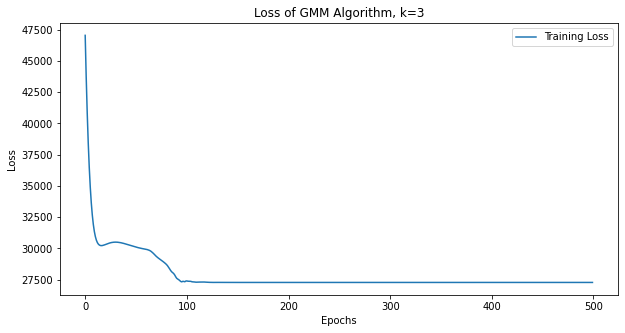

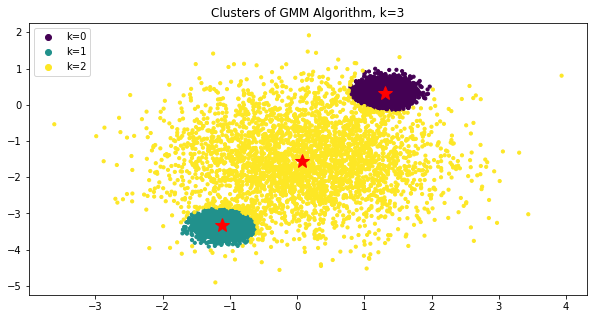

In [0]:
'''
Question 2.2.1

Run GMM with no validation set
'''

trainData, _ = getData()
runGMM(trainData, K=3, epochs=500)

Final Training Loss: 20070.162109375
Final Validation Loss: 10043.6728515625
------------------------------------------------
Percentage of points in each cluster:
K=0: 100.0%


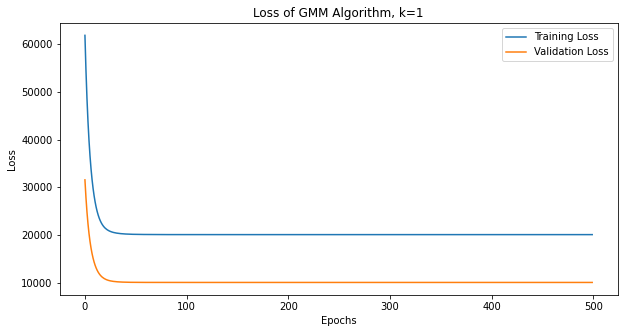

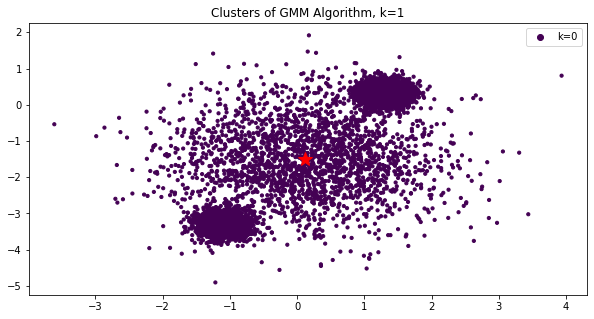

In [0]:
'''
Question 2.2.2

Run GMM with validation set
'''

trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=1, epochs=500)

Final Training Loss: 19071.751953125
Final Validation Loss: 9454.9521484375
------------------------------------------------
Percentage of points in each cluster:
K=0: 65.79%
K=1: 34.21%


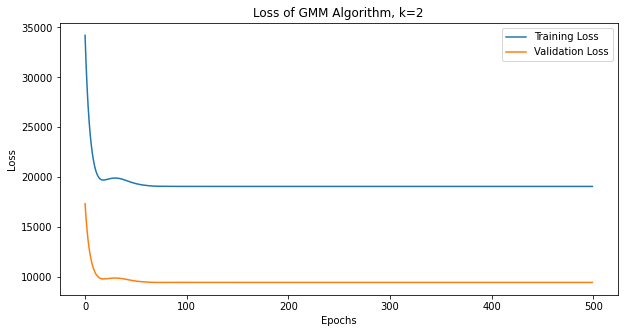

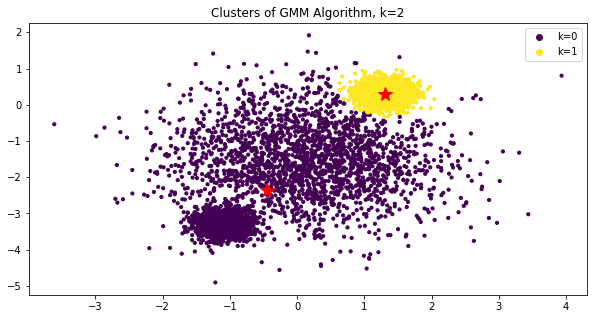

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=2, epochs=500)

Final Training Loss: 7088.037109375
Final Validation Loss: 3511.4482421875
------------------------------------------------
Percentage of points in each cluster:
K=0: 36.54%
K=1: 32.22%
K=2: 31.24%


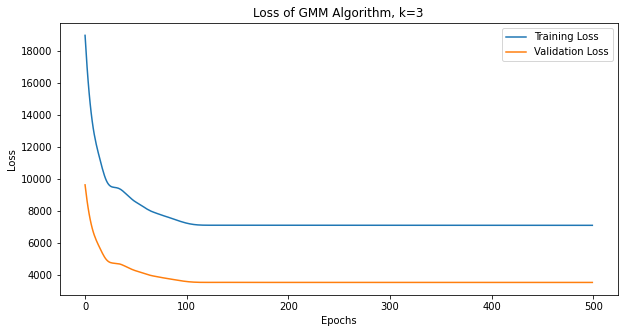

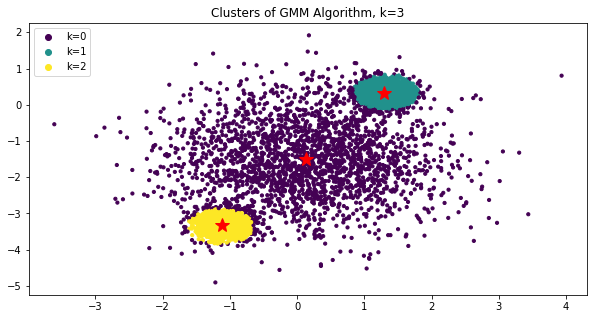

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=3, epochs=500)

Final Training Loss: 17609.240234375
Final Validation Loss: 8805.3232421875
------------------------------------------------
Percentage of points in each cluster:
K=0: 16.81%
K=1: 33.45%
K=2: 34.26%
K=3: 15.48%


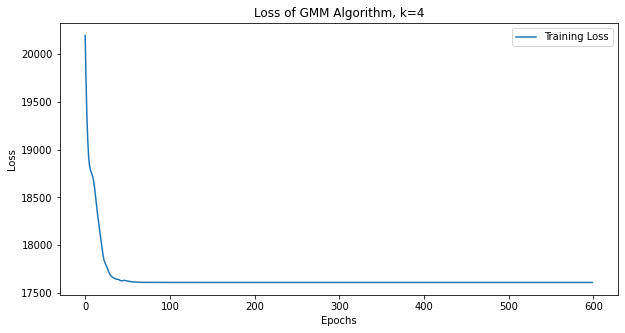

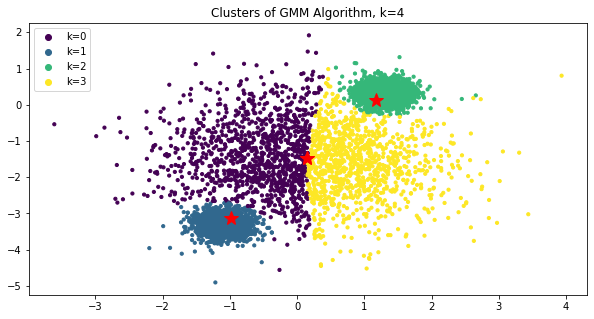

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=4, epochs=600)

Final Training Loss: 15308.2724609375
Final Validation Loss: 7655.5361328125
------------------------------------------------
Percentage of points in each cluster:
K=0: 34.86%
K=1: 34.32%
K=2: 14.79%
K=3: 16.03%


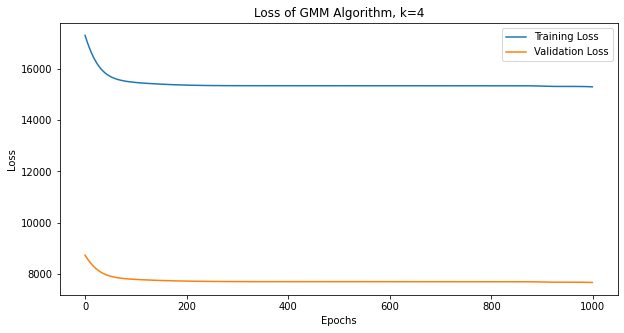

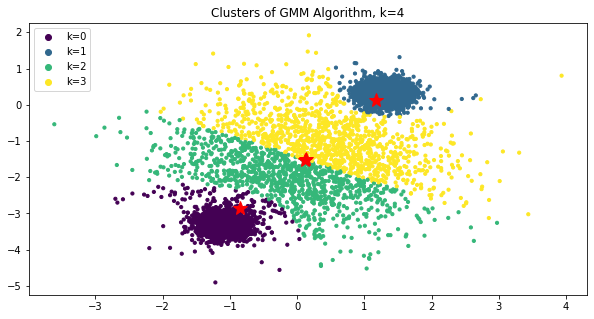

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=4, epochs=1000)

Final Training Loss: 18524.990234375
Final Validation Loss: 9217.509765625
------------------------------------------------
Percentage of points in each cluster:
K=0: 66.67%
K=1: 10.21%
K=2: 18.72%
K=3: 4.39%


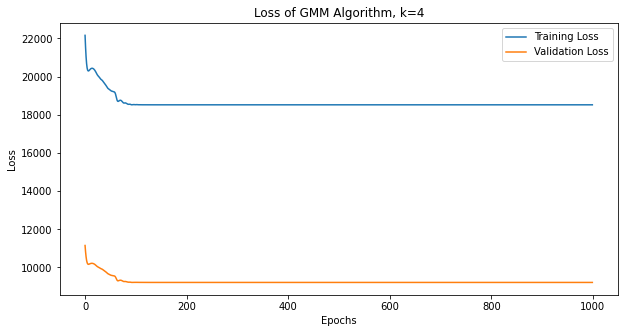

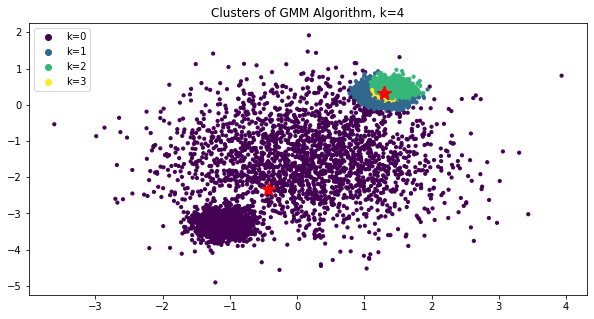

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=4, epochs=1000)

Final Training Loss: 17277.900390625
Final Validation Loss: 8585.943359375
------------------------------------------------
Percentage of points in each cluster:
K=0: 33.81%
K=1: 33.51%
K=2: 0.0%
K=3: 32.68%


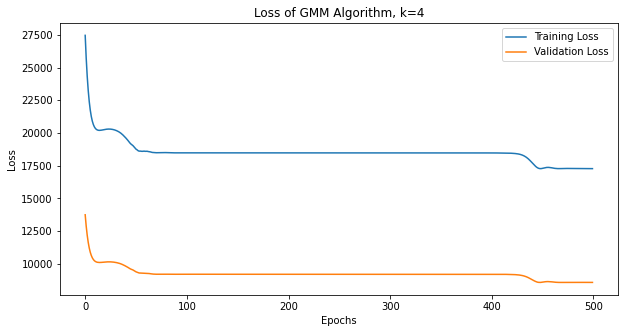

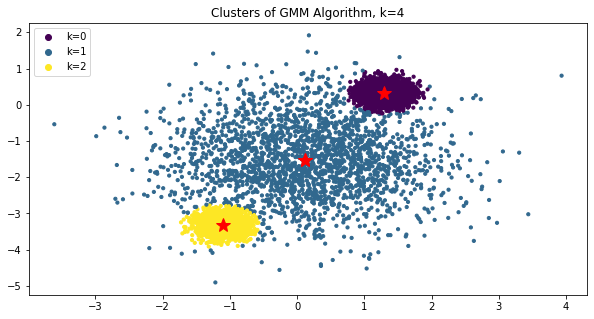

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=4, epochs=500)

Final Training Loss: 15307.4375
Final Validation Loss: 7656.74072265625
------------------------------------------------
Percentage of points in each cluster:
K=0: 15.28%
K=1: 33.46%
K=2: 0.0%
K=3: 17.02%
K=4: 34.23%


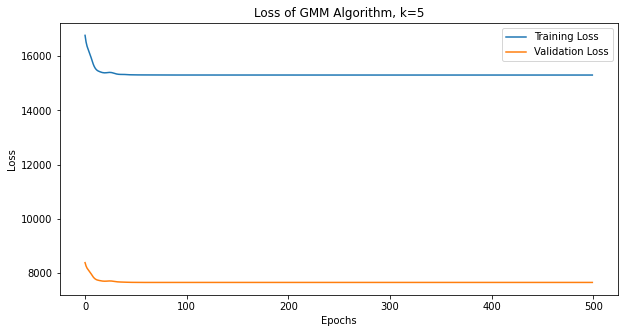

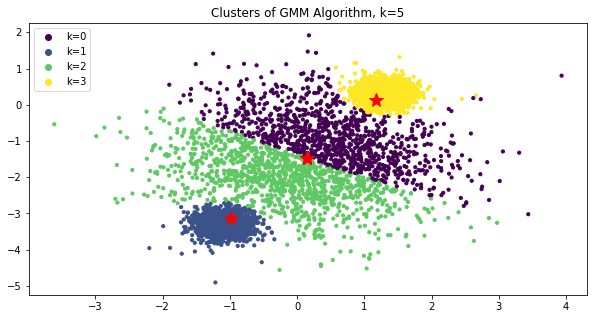

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=5, epochs=500)

Final Training Loss: 15307.4306640625
Final Validation Loss: 7656.74072265625
------------------------------------------------
Percentage of points in each cluster:
K=0: 11.29%
K=1: 13.39%
K=2: 33.46%
K=3: 7.6%
K=4: 34.24%


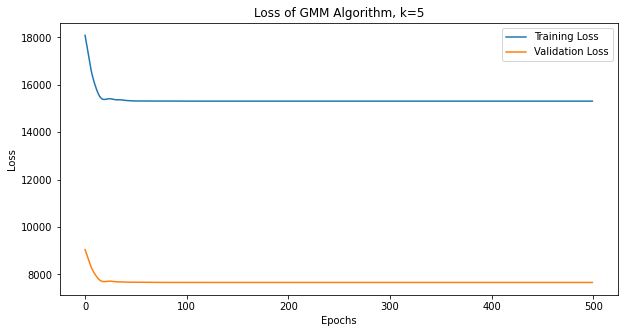

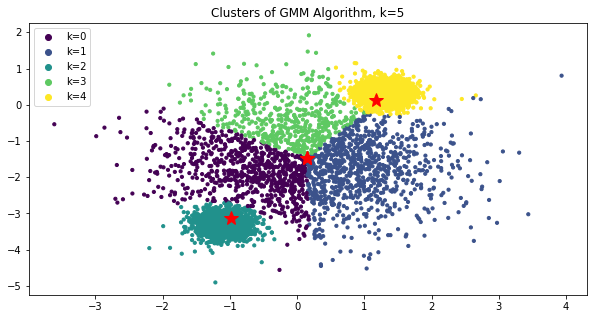

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=5, epochs=500)

Final Training Loss: 15307.423828125
Final Validation Loss: 7656.72705078125
------------------------------------------------
Percentage of points in each cluster:
K=0: 7.5%
K=1: 9.94%
K=2: 14.85%
K=3: 34.24%
K=4: 33.46%


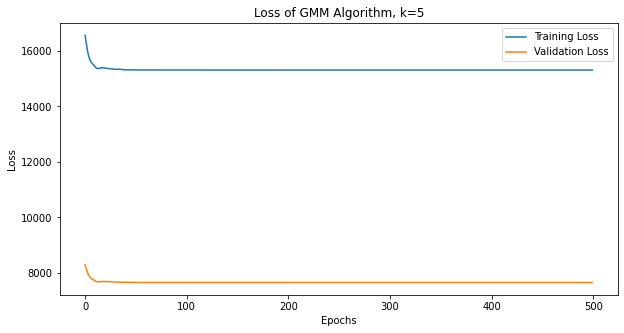

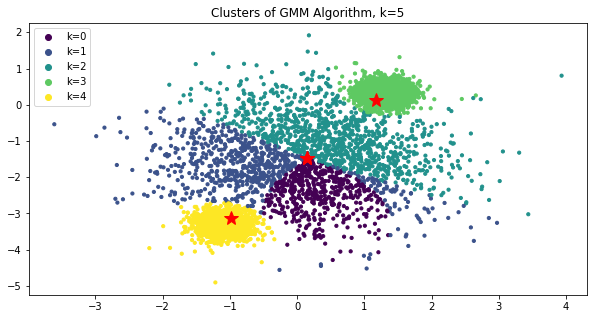

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=5, epochs=500)

Final Training Loss: 17277.728515625
Final Validation Loss: 8584.66796875
------------------------------------------------
Percentage of points in each cluster:
K=0: 0.0%
K=1: 32.79%
K=2: 33.37%
K=3: 0.0%
K=4: 33.84%


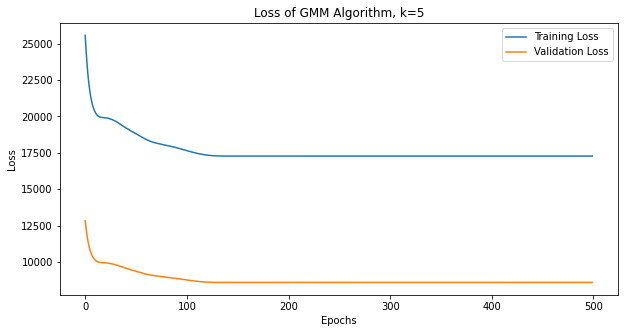

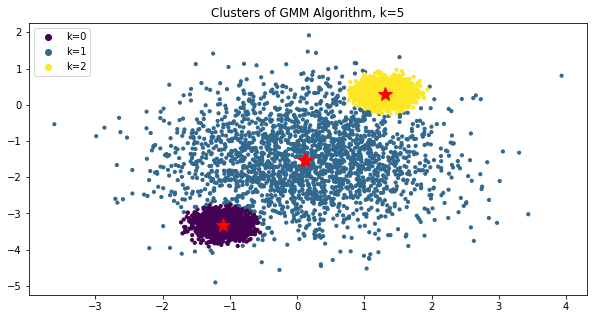

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=5, epochs=500)

Final Training Loss: 17603.482421875
Final Validation Loss: 8759.3623046875
------------------------------------------------
Percentage of points in each cluster:
K=0: 18.25%
K=1: 37.2%
K=2: 18.73%
K=3: 13.14%
K=4: 12.67%


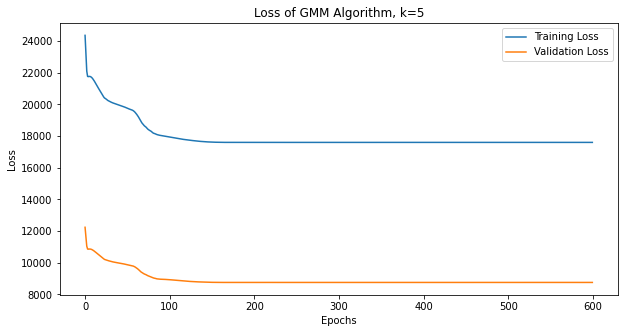

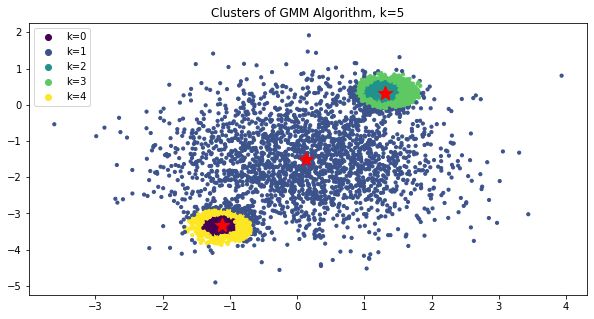

In [0]:
trainData, validData = getData(is_valid=True)
runGMMHoldout(trainData, validData, K=5, epochs=600)

In [0]:
'''
Question 2.3.3
Run models on 100D model
'''

trainData, validData = getData(is_valid=True, use100D=True)
runKNNHoldout(trainData, validData, K=5, epochs=500, plot=False)

Final Training Loss: 36815.71875
Final Validation Loss: 18443.849609375
------------------------------------------------
Percentage of points in each cluster:
K=0: 39.33%
K=1: 20.35%
K=2: 9.57%
K=3: 10.71%
K=4: 20.04%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runKNNHoldout(trainData, validData, K=10, epochs=500, plot=False)

Final Training Loss: 28382.607421875
Final Validation Loss: 14239.4482421875
------------------------------------------------
Percentage of points in each cluster:
K=0: 20.35%
K=1: 7.18%
K=2: 6.09%
K=3: 10.02%
K=4: 0.0%
K=5: 0.0%
K=6: 0.03%
K=7: 29.31%
K=8: 20.01%
K=9: 7.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runKNNHoldout(trainData, validData, K=15, epochs=500, plot=False)

Final Training Loss: 28335.8984375
Final Validation Loss: 14222.3505859375
------------------------------------------------
Percentage of points in each cluster:
K=0: 20.35%
K=1: 5.83%
K=2: 0.0%
K=3: 0.0%
K=4: 0.0%
K=5: 10.02%
K=6: 0.0%
K=7: 4.51%
K=8: 0.0%
K=9: 20.04%
K=10: 5.22%
K=11: 4.71%
K=12: 0.0%
K=13: 0.0%
K=14: 29.31%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runKNNHoldout(trainData, validData, K=20, epochs=500, plot=False)

Final Training Loss: 28040.978515625
Final Validation Loss: 14114.4912109375
------------------------------------------------
Percentage of points in each cluster:
K=0: 2.7%
K=1: 10.02%
K=2: 0.0%
K=3: 2.07%
K=4: 14.97%
K=5: 0.0%
K=6: 1.93%
K=7: 20.04%
K=8: 0.0%
K=9: 2.38%
K=10: 20.35%
K=11: 0.01%
K=12: 1.72%
K=13: 0.0%
K=14: 14.32%
K=15: 2.35%
K=16: 2.38%
K=17: 0.0%
K=18: 2.14%
K=19: 2.58%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runKNNHoldout(trainData, validData, K=30, epochs=500, plot=False)

Final Training Loss: 28077.728515625
Final Validation Loss: 14115.7978515625
------------------------------------------------
Percentage of points in each cluster:
K=0: 0.01%
K=1: 0.0%
K=2: 10.39%
K=3: 3.27%
K=4: 0.0%
K=5: 10.02%
K=6: 0.0%
K=7: 0.0%
K=8: 0.0%
K=9: 0.0%
K=10: 0.0%
K=11: 0.01%
K=12: 4.11%
K=13: 4.81%
K=14: 4.45%
K=15: 0.0%
K=16: 9.48%
K=17: 0.0%
K=18: 0.0%
K=19: 3.63%
K=20: 0.0%
K=21: 20.04%
K=22: 20.35%
K=23: 9.4%
K=24: 0.0%
K=25: 0.0%
K=26: 0.0%
K=27: 0.0%
K=28: 0.0%
K=29: 0.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runGMMHoldout(trainData, validData, K=5, epochs=500, plot=False)

Final Training Loss: 30944.78125
Final Validation Loss: 15461.73046875
------------------------------------------------
Percentage of points in each cluster:
K=0: 10.02%
K=1: 0.0%
K=2: 0.0%
K=3: 89.98%
K=4: 0.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runGMMHoldout(trainData, validData, K=10, epochs=500, plot=False)

Final Training Loss: 30943.763671875
Final Validation Loss: 15461.2255859375
------------------------------------------------
Percentage of points in each cluster:
K=0: 100.0%
K=1: 0.0%
K=2: 0.0%
K=3: 0.0%
K=4: 0.0%
K=5: 0.0%
K=6: 0.0%
K=7: 0.0%
K=8: 0.0%
K=9: 0.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runGMMHoldout(trainData, validData, K=15, epochs=500, plot=False)

Final Training Loss: 30943.76171875
Final Validation Loss: 15461.224609375
------------------------------------------------
Percentage of points in each cluster:
K=0: 0.0%
K=1: 0.0%
K=2: 0.0%
K=3: 0.0%
K=4: 100.0%
K=5: 0.0%
K=6: 0.0%
K=7: 0.0%
K=8: 0.0%
K=9: 0.0%
K=10: 0.0%
K=11: 0.0%
K=12: 0.0%
K=13: 0.0%
K=14: 0.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runGMMHoldout(trainData, validData, K=20, epochs=500, plot=False)

Final Training Loss: 30943.76171875
Final Validation Loss: 15461.224609375
------------------------------------------------
Percentage of points in each cluster:
K=0: 0.0%
K=1: 0.0%
K=2: 0.0%
K=3: 0.0%
K=4: 0.0%
K=5: 0.0%
K=6: 0.0%
K=7: 0.0%
K=8: 0.0%
K=9: 0.0%
K=10: 0.0%
K=11: 0.0%
K=12: 0.0%
K=13: 0.0%
K=14: 0.0%
K=15: 100.0%
K=16: 0.0%
K=17: 0.0%
K=18: 0.0%
K=19: 0.0%


In [0]:
trainData, validData = getData(is_valid=True, use100D=True)
runGMMHoldout(trainData, validData, K=30, epochs=500, plot=False)

Final Training Loss: 30943.763671875
Final Validation Loss: 15461.2255859375
------------------------------------------------
Percentage of points in each cluster:
K=0: 100.0%
K=1: 0.0%
K=2: 0.0%
K=3: 0.0%
K=4: 0.0%
K=5: 0.0%
K=6: 0.0%
K=7: 0.0%
K=8: 0.0%
K=9: 0.0%
K=10: 0.0%
K=11: 0.0%
K=12: 0.0%
K=13: 0.0%
K=14: 0.0%
K=15: 0.0%
K=16: 0.0%
K=17: 0.0%
K=18: 0.0%
K=19: 0.0%
K=20: 0.0%
K=21: 0.0%
K=22: 0.0%
K=23: 0.0%
K=24: 0.0%
K=25: 0.0%
K=26: 0.0%
K=27: 0.0%
K=28: 0.0%
K=29: 0.0%
